In [1]:
!python --version

Python 3.10.6


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#autoreload permite que jupyter vea las modif de los script de forma automática
%load_ext autoreload
%autoreload 2

Importamos datos

In [4]:
path = "tests/waveforms/"
q_train = np.load(path+"q_train_1d-seed_eq_1.npy")
q_test = np.load(path+"q_test_1d-seed_eq_1.npy")
ts_train = np.load(path+"ts_train_1d-seed_eq_1.npy")
ts_test = np.load(path+"ts_test_1d-seed_eq_1.npy")
times = np.load(path+"times_1d-seed_eq_1.npy")

q = [8. 0. 0.]


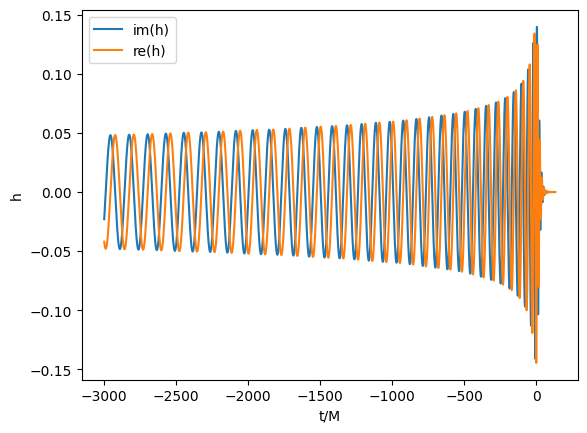

In [5]:
idx = 1
print(f"q = {q_train[idx]}")
plt.xlabel("t/M")
plt.ylabel("h")
plt.plot(times,np.imag(ts_train[idx]), label="im(h)")
plt.plot(times,np.real(ts_train[idx]), label="re(h)")
plt.legend();

Importamos la clase ReducedBasis, diseñada al estilo sci-kit y entrenamos un modelo hp-greedy.

In [6]:
from skreducedmodel.reducedbasis import ReducedBasis

rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 2,
                  nmax = 5,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

Visualizamos el orden de las particiones realizadas

In [7]:
from anytree import RenderTree

def visual_tree(tree):
    for pre, fill, node in RenderTree(tree):
        print("%s%s" % (pre, node.name))

visual_tree(rb.tree)

(0,)
├── (0, 0)
│   ├── (0, 0, 0)
│   └── (0, 0, 1)
└── (0, 1)
    ├── (0, 1, 0)
    └── (0, 1, 1)


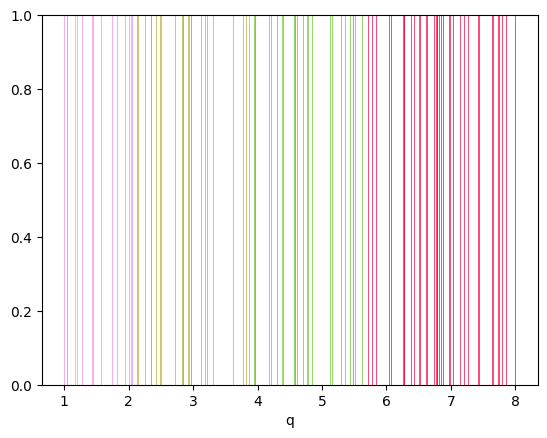

In [8]:
np.random.seed(seed=4)
plt.xlabel("q")
for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Vemos el error en función del parámetro q

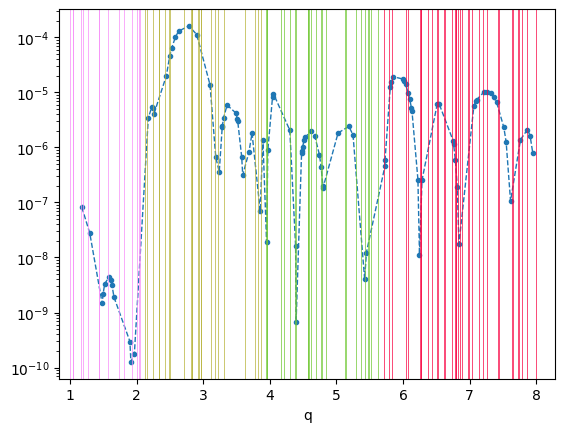

In [36]:
from skreducedmodel.reducedbasis import normalize_set, error

# normalizamos el conjunto de ondas de testeo
ts_test_normalized = normalize_set(ts_test, times)

# calculamos la proyección de las ondas con el modelo hp-greedy
hts = []
for h, q in zip(ts_test_normalized, q_test):
    hts.append(rb.transform(h,q))
hts = np.array(hts)

# calculamos el error para cada una de las proyecciones
errors = []
for i in range(ts_test_normalized.shape[0]):
    errors.append(error(ts_test_normalized[i], hts[i], times))

# graficamos la dependencia de los errores con respecto al parámetro q
plt.yscale("log")
plt.plot(np.sort(q_test[:,0]), np.array(errors)[np.argsort(q_test[:,0])], "o--", ms=3, lw=1);

np.random.seed(seed=4)
plt.xlabel("q")
for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Ploteamos una onda proyectada vs la normal

Veamos la variación del error frente a diferentes hiperparámetros Lmax y Nmax

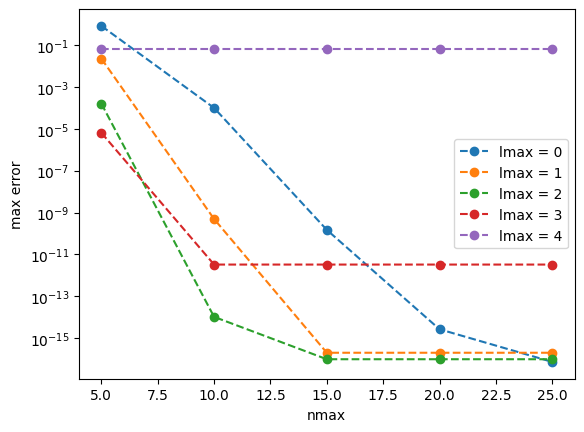

In [57]:
from skreducedmodel.reducedbasis import ReducedBasis

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = 0,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

En el enfoque de bases reducidas, una menor dimensionalidad de la base implica representaciones con menor costo computacional para ser evaluadas.

Se puede ver que existen casos que para llegar a una precision dada, al particionar el dominio se obtienen bases con dimensionalidad menor que una global.

Por ejemplo, para llegar a representaciones con error máximo de ~ 10e(-14), con lmax = 0 (sin particion) se necesita una base de dimension ~20, mientras con lmax=2 se necesitan bases de a lo sumo dimensión 10.

Ahora probamos el mismo experimento con otra semilla:

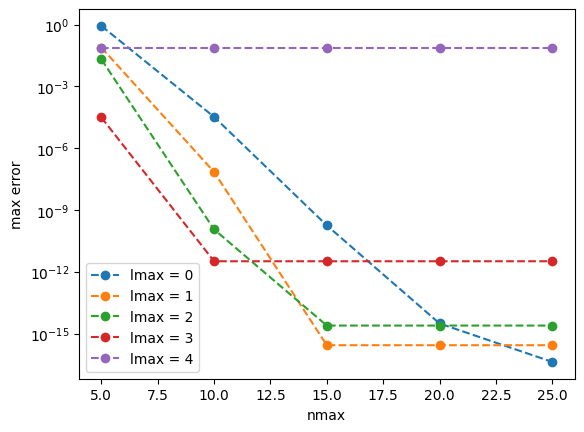

In [58]:
index_seed_global_rb = -1

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

Se puede ver que hay una dependencia de los errores con respecto a la semilla.

Por lo tanto, esta se puede tomar como un hiperparámetro "relevante" del modelo.

Se menciona como "relevante" debido a que en el caso sin partición la elección de la semilla otorga resultados que se pueden tomar como equivalentes, debido a que en estudios realizados anteriormente se muestra como esta no afecta a la capacidad de representacion de las bases resultantes, más allá de que estas pueden no ser construidas exactamente con los mismos elementos del espacio de entrenamiento.